## GLM Auto Risk Scoring

## Importing the Dataset

In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
# import data
cars = pd.read_csv("data/Kia_Data2.csv", na_values="?").dropna()

In [107]:
# print the first five lines
cars.head()

,auction_code,car_year,color,make,model,subseries,body,engine,transmission,mileage,condition_grade,times_run,seller,sale_price,sold_date,season,region
0,EDMO,2015,SILVER,KIA,RIO,LX,4DSN,4G,6,1892,46,1,5361856,8500,9/27/2018,Fall,Canada
1,TAA,2017,WHITE,KIA,FORTE,LX,4DSN,4G,A,2831,50,1,5357510,14000,5/2/2017,Spring,Canada
2,EDMO,2018,BLACK,KIA,SORENTO AWD 4C,LX,SUV,4G,A,5478,45,2,4920595,22500,7/19/2018,Summer,Canada
3,TAA,2018,MAROON,KIA,SEDONA,SX+,VAN,6G,A,6800,46,2,4998915,28000,3/20/2018,Spring,Canada
4,EDMO,2016,GRAY,KIA,OPTIMA,LX,4DSN,4G,A,9358,40,1,4903345,14000,5/10/2018,Spring,Canada


In [108]:
# list basic info
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71199 entries, 0 to 71201
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   auction_code     71199 non-null  object
 1   car_year         71199 non-null  int64 
 2   color            71199 non-null  object
 3   make             71199 non-null  object
 4   model            71199 non-null  object
 5   subseries        71199 non-null  object
 6   body             71199 non-null  object
 7   engine           71199 non-null  object
 8   transmission     71199 non-null  object
 9   mileage          71199 non-null  int64 
 10  condition_grade  71199 non-null  object
 11  times_run        71199 non-null  int64 
 12  seller           71199 non-null  int64 
 13  sale_price       71199 non-null  int64 
 14  sold_date        71199 non-null  object
 15  season           71199 non-null  object
 16  region           71199 non-null  object
dtypes: int64(5), object(12)
memory 

In [109]:
# Find all the unique condition grades.
print(cars["condition_grade"].unique())

# Replace all the occurences of codes with the corresponding numbers.
cars.loc[cars["condition_grade"] == "AV", "condition_grade"] = '30'
cars.loc[cars["condition_grade"] == "SL", "condition_grade"] = '0'
cars.loc[cars["condition_grade"] == "CL", "condition_grade"] = '40'
cars.loc[cars["condition_grade"] == "EC", "condition_grade"] = '50'
cars.loc[cars["condition_grade"] == "PR", "condition_grade"] = '10'
cars.loc[cars["condition_grade"] == "RG", "condition_grade"] = '20'

['46' '50' '45' '40' '41' '38' '48' '43' '47' '49' '26' '27' '15' '44'
 '36' '42' '37' '35' '24' '31' '34' '33' 'AV' 'CL' '28' '39' '29' '14'
 '18' '32' '30' '25' '21' '20' '16' '19' '23' '22' '17' '13' 'RG' 'PR'
 'SL' 'EC' '10' '0' '12' '11' '1']


In [110]:
print(cars["condition_grade"].unique())

['46' '50' '45' '40' '41' '38' '48' '43' '47' '49' '26' '27' '15' '44'
 '36' '42' '37' '35' '24' '31' '34' '33' '30' '28' '39' '29' '14' '18'
 '32' '25' '21' '20' '16' '19' '23' '22' '17' '13' '10' '0' '12' '11' '1']


In [111]:
print(cars["transmission"].unique())
cars.loc[cars['transmission'] == 'M', 'transmission'] = 1
cars.loc[cars['transmission'] == 'A', 'transmission'] = 0
cars.loc[cars['transmission'] == '5', 'transmission'] = 0
cars.loc[cars['transmission'] == '6', 'transmission'] = 0
cars.loc[cars['transmission'] == 'O', 'transmission'] = 0
cars.loc[cars['transmission'] == 'P', 'transmission'] = 0
cars.loc[cars['transmission'] == 'Z', 'transmission'] = 0
cars.loc[cars['transmission'] == 'C', 'transmission'] = 0
cars.loc[cars['transmission'] == 'N', 'transmission'] = 0

['6' 'A' '5' 'O' 'P' 'C' 'M' 'N' 'Z']


In [112]:
print(cars["transmission"].unique())

[0 1]


In [113]:
print(cars["model"].unique())

['RIO' 'FORTE' 'SORENTO AWD 4C' 'SEDONA' 'OPTIMA' 'SOUL' 'SPORTAGE AWD 4C'
 'SORENTO FWD 4C' 'SORENTO LX AWD' 'SOUL EV' 'SPORTAGE FWD 4C' 'RONDO'
 'SORENTO AWD V6' 'CADENZA' 'RIO 5' 'RIO LX' 'FORTE LX +' 'FORTE EX AT'
 'SORENTO FWD V6' 'SPORTAGE LX FWD' 'SPORTAGE 4X4 4C' 'FORTE 5' 'SOUL EX+'
 'SOREN LX+ TURBO' 'RIO LX + MT' 'SPORTAGE     4C' 'SPECTRA' 'SOUL EX'
 'RONDO V6' 'SORENTO 4X4 V6' 'RONDO 4C' 'SPORTAGE LX' 'FORTE LX+MT'
 'SPORTAGE 4X2 4C' 'OPTIMA 4C' 'SORENTO 4C' 'SORENTO V6' 'SPORTAGE FWD V6'
 'SORENTO 4X4' 'RONDO FWD 4C' 'SPORTAGE 4X4 V6' 'SPECTRA5' 'BORREGO V6'
 'BORREGO 4X4 V6' 'SPORTAGE V6' 'SPORTAGE 4X2 V6' 'RONDO FWD V6'
 'SORENTO 4X2' 'NIRO' 'K900' 'STINGER AWD V6' 'STINGER 4X2 4C'
 'NIRO PLUG-IN' 'SPORTAGE FWD' 'FORTE5' 'STINGER 4X2 V6' 'SPORTAGE AWD'
 'STINGER AWD 4C' 'SORENTO AWD' 'SORENTO FWD' 'K900 V8' 'K900 V6'
 'OPTIMA V6' 'SORENTO 4X2 V6' 'BORREGO 4X2 V6' 'SEPHIA' 'SPORTAGE 4X4'
 'BORREGO 4X2 V8' 'BORREGO 4X4 V8' 'SPORTAGE 4X2' 'FORT' 'OPTIMA SX LTD'
 'SORENTO -

In [114]:
model_names = []
for model in cars.model[1:]:
    a_string = model
    first_word = a_string.split()[0]
    print(first_word)

FORTE
SORENTO
SEDONA
OPTIMA
OPTIMA
SORENTO
SOUL
SPORTAGE
OPTIMA
SOUL
SOUL
RIO
SEDONA
SOUL
FORTE
SORENTO
SEDONA
SOUL
RIO
SOUL
SOUL
SORENTO
SOUL
FORTE
SORENTO
SORENTO
FORTE
FORTE
RIO
RIO
SPORTAGE
SPORTAGE
SOUL
RIO
RIO
RIO
SPORTAGE
SPORTAGE
SOUL
SPORTAGE
FORTE
SEDONA
SOUL
SORENTO
OPTIMA
RIO
RIO
SOUL
RIO
SPORTAGE
SORENTO
FORTE
RIO
SOUL
OPTIMA
RIO
FORTE
SORENTO
OPTIMA
FORTE
SEDONA
RIO
FORTE
SOUL
RIO
SORENTO
RONDO
RIO
SPORTAGE
RIO
SOUL
FORTE
RIO
OPTIMA
OPTIMA
SOUL
RIO
OPTIMA
RIO
FORTE
FORTE
SOUL
RIO
SOUL
SEDONA
SORENTO
RIO
SORENTO
RIO
RIO
RIO
RIO
FORTE
FORTE
FORTE
FORTE
FORTE
SOUL
OPTIMA
FORTE
FORTE
SEDONA
FORTE
SOUL
RIO
FORTE
SPORTAGE
FORTE
FORTE
RIO
RIO
FORTE
SOUL
RIO
RIO
RIO
FORTE
SOUL
SPORTAGE
SOUL
RIO
SOUL
SOUL
FORTE
RIO
CADENZA
FORTE
RIO
OPTIMA
SORENTO
RIO
OPTIMA
SOUL
FORTE
FORTE
OPTIMA
SOUL
RIO
RIO
SPORTAGE
FORTE
RIO
SOUL
SOUL
SOUL
FORTE
SOUL
RIO
FORTE
SOUL
SOUL
RIO
RIO
RIO
FORTE
RIO
OPTIMA
OPTIMA
FORTE
FORTE
RIO
OPTIMA
FORTE
OPTIMA
SORENTO
OPTIMA
SOUL
SOUL
FORTE
SOUL
FORTE
FORTE
FORT

SEDONA
SPORTAGE
FORTE
OPTIMA
SPORTAGE
SORENTO
RIO
OPTIMA
SEDONA
OPTIMA
OPTIMA
SEDONA
SORENTO
SORENTO
FORTE
SORENTO
OPTIMA
FORTE
FORTE
SPORTAGE
RIO
FORTE
OPTIMA
SOUL
OPTIMA
SEDONA
SOUL
RIO
FORTE
SOUL
SEDONA
FORTE
SPORTAGE
OPTIMA
SORENTO
SEDONA
FORTE
SEDONA
SORENTO
SORENTO
SPORTAGE
SORENTO
SEDONA
SOUL
FORTE
SORENTO
SOUL
OPTIMA
SEDONA
FORTE
SPORTAGE
OPTIMA
FORTE
SEDONA
OPTIMA
SEDONA
FORTE
FORTE
SOUL
SOUL
FORTE
SOUL
RIO
SOUL
FORTE
SPORTAGE
K900
FORTE
SEDONA
SEDONA
FORTE
SOUL
NIRO
FORTE
FORTE
SORENTO
OPTIMA
FORTE
FORTE
SOUL
SORENTO
SORENTO
SOUL
SORENTO
SPORTAGE
FORTE
SEDONA
OPTIMA
SORENTO
SORENTO
OPTIMA
SORENTO
OPTIMA
SORENTO
OPTIMA
SOUL
SOUL
OPTIMA
OPTIMA
OPTIMA
FORTE
SEDONA
SEDONA
SORENTO
OPTIMA
FORTE
RIO
SPORTAGE
OPTIMA
SOUL
SOUL
OPTIMA
OPTIMA
SORENTO
FORTE
SOUL
OPTIMA
RIO
SEDONA
FORTE
SORENTO
SEDONA
SORENTO
SEDONA
FORTE
SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SOUL
SPORTAGE
SEDONA
SORENTO
SEDONA
SOUL
SOUL
FORTE
OPTIMA
OPTIMA
RIO
SORENTO
SOUL
OPTIMA
SOUL
FORTE
SOUL
OPTIMA
SEDONA
OPTIMA


FORTE
OPTIMA
OPTIMA
OPTIMA
FORTE
SORENTO
OPTIMA
FORTE
SOUL
FORTE
OPTIMA
SORENTO
OPTIMA
SPORTAGE
SEDONA
SORENTO
SOUL
SORENTO
OPTIMA
SEDONA
OPTIMA
SEDONA
OPTIMA
FORTE
OPTIMA
OPTIMA
SEDONA
FORTE
SEDONA
SOUL
SORENTO
SEDONA
SORENTO
NIRO
SORENTO
OPTIMA
SPORTAGE
SPORTAGE
RIO
OPTIMA
FORTE
SEDONA
RIO
FORTE
RIO
SEDONA
OPTIMA
SPORTAGE
SOUL
SPORTAGE
RIO
SPORTAGE
SORENTO
FORTE
SORENTO
SEDONA
SEDONA
OPTIMA
FORTE
OPTIMA
FORTE
OPTIMA
OPTIMA
SORENTO
SEDONA
SEDONA
SORENTO
SORENTO
SPORTAGE
OPTIMA
SOUL
SPORTAGE
SORENTO
SORENTO
OPTIMA
OPTIMA
SORENTO
OPTIMA
SORENTO
STINGER
SORENTO
OPTIMA
OPTIMA
CADENZA
SORENTO
FORTE
OPTIMA
SPORTAGE
SEDONA
OPTIMA
FORTE
SORENTO
OPTIMA
SPORTAGE
SEDONA
OPTIMA
SOUL
OPTIMA
FORTE
OPTIMA
SEDONA
CADENZA
SOUL
OPTIMA
SEDONA
SPORTAGE
FORTE
SEDONA
SORENTO
SORENTO
FORTE
SORENTO
SORENTO
SEDONA
SPORTAGE
OPTIMA
OPTIMA
SEDONA
SEDONA
OPTIMA
SPORTAGE
SOUL
OPTIMA
FORTE
FORTE
FORTE
OPTIMA
FORTE
SEDONA
SEDONA
SPORTAGE
SORENTO
SEDONA
OPTIMA
SEDONA
OPTIMA
RIO
SORENTO
SPORTAGE
SORENTO
OPTIMA
SEDONA


SORENTO
OPTIMA
SPORTAGE
OPTIMA
SOUL
SOUL
OPTIMA
SOUL
SOUL
OPTIMA
SOUL
OPTIMA
SPORTAGE
OPTIMA
SOUL
SORENTO
FORTE
SORENTO
OPTIMA
SORENTO
SORENTO
OPTIMA
SORENTO
OPTIMA
FORTE
FORTE
FORTE
SORENTO
SOUL
FORTE
OPTIMA
SPORTAGE
SORENTO
SOUL
SORENTO
OPTIMA
SOUL
OPTIMA
SOUL
SORENTO
OPTIMA
SORENTO
FORTE
RIO
RIO
SPORTAGE
OPTIMA
SOUL
OPTIMA
OPTIMA
OPTIMA
FORTE
OPTIMA
FORTE
CADENZA
SEDONA
OPTIMA
OPTIMA
K900
OPTIMA
OPTIMA
OPTIMA
SORENTO
OPTIMA
SORENTO
SORENTO
OPTIMA
OPTIMA
SORENTO
FORTE
SORENTO
OPTIMA
FORTE
RIO
SORENTO
SORENTO
OPTIMA
SOUL
FORTE
SORENTO
SPORTAGE
SORENTO
SOUL
OPTIMA
FORTE
OPTIMA
SOUL
OPTIMA
OPTIMA
SOUL
FORTE
SORENTO
SEDONA
FORTE
OPTIMA
OPTIMA
OPTIMA
FORTE
OPTIMA
SOUL
OPTIMA
SOUL
OPTIMA
RIO
OPTIMA
SPORTAGE
FORTE
OPTIMA
SORENTO
OPTIMA
SORENTO
SPORTAGE
FORTE
OPTIMA
SORENTO
FORTE
FORTE
OPTIMA
SPORTAGE
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SEDONA
SOUL
SORENTO
SORENTO
OPTIMA
SORENTO
SOUL
OPTIMA
SOUL
OPTIMA
FORTE
OPTIMA
SORENTO
OPTIMA
SOUL
FORTE
SORENTO
SOUL
SORENTO
OPTIMA
SORENTO
OPTIMA
SORENTO
K900
SOU

SPORTAGE
OPTIMA
OPTIMA
OPTIMA
OPTIMA
FORTE
SPORTAGE
OPTIMA
SORENTO
OPTIMA
SPORTAGE
OPTIMA
FORTE
OPTIMA
SEDONA
SORENTO
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
SOUL
SEDONA
OPTIMA
SPORTAGE
OPTIMA
SPORTAGE
SORENTO
FORTE
FORTE
FORTE
SPORTAGE
SORENTO
SORENTO
OPTIMA
OPTIMA
SOUL
OPTIMA
SORENTO
OPTIMA
SOUL
OPTIMA
CADENZA
SEDONA
OPTIMA
SEDONA
OPTIMA
SOUL
SPORTAGE
SORENTO
SEDONA
SEDONA
SPORTAGE
SPORTAGE
OPTIMA
OPTIMA
SOUL
SORENTO
SPORTAGE
OPTIMA
SEDONA
FORTE
OPTIMA
SPORTAGE
OPTIMA
FORTE
SEDONA
FORTE
OPTIMA
SORENTO
FORTE
SOUL
OPTIMA
OPTIMA
SPORTAGE
SEDONA
SPORTAGE
SORENTO
SOUL
FORTE
SEDONA
SOUL
SPORTAGE
SOUL
RIO
OPTIMA
OPTIMA
SEDONA
OPTIMA
RIO
SORENTO
OPTIMA
SORENTO
OPTIMA
CADENZA
SORENTO
OPTIMA
SORENTO
SORENTO
OPTIMA
OPTIMA
OPTIMA
SORENTO
OPTIMA
FORTE
SEDONA
OPTIMA
OPTIMA
OPTIMA
SOUL
OPTIMA
OPTIMA
SPORTAGE
SORENTO
SPORTAGE
OPTIMA
OPTIMA
SOUL
OPTIMA
SPORTAGE
OPTIMA
SPORTAGE
OPTIMA
OPTIMA
FORTE
SOUL
SEDONA
OPTIMA
OPTIMA
SOUL
SEDONA
OPTIMA
SORENTO
OPTIMA
SPORTAGE
OPTIMA
SEDONA
OPTIMA
RIO
SORENTO
RIO
OP

SORENTO
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
FORTE
SORENTO
FORTE
OPTIMA
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SOUL
SEDONA
SPORTAGE
FORTE
BORREGO
OPTIMA
SORENTO
FORTE
OPTIMA
OPTIMA
SOUL
OPTIMA
OPTIMA
SORENTO
OPTIMA
SPORTAGE
SOUL
SPORTAGE
SORENTO
OPTIMA
FORTE
OPTIMA
SORENTO
SOUL
SPORTAGE
RIO
SORENTO
SPORTAGE
SOUL
SEDONA
OPTIMA
OPTIMA
RONDO
SOUL
OPTIMA
SPORTAGE
OPTIMA
SPORTAGE
SORENTO
RONDO
SORENTO
SOUL
SOUL
OPTIMA
SORENTO
OPTIMA
OPTIMA
OPTIMA
FORTE
SOUL
OPTIMA
OPTIMA
SORENTO
SORENTO
SORENTO
FORTE
SPORTAGE
SOUL
FORTE
SORENTO
SPORTAGE
OPTIMA
SEDONA
SORENTO
SOUL
OPTIMA
OPTIMA
OPTIMA
FORTE
OPTIMA
OPTIMA
SEDONA
RIO
SORENTO
OPTIMA
OPTIMA
SORENTO
OPTIMA
FORTE
SEDONA
SORENTO
OPTIMA
OPTIMA
OPTIMA
SOUL
FORTE
SOUL
FORTE
OPTIMA
OPTIMA
RIO
FORTE
SOUL
SPECTRA
SOUL
SORENTO
SEDONA
SORENTO
OPTIMA
OPTIMA
SOUL
OPTIMA
SORENTO
OPTIMA
OPTIMA
FORTE
SORENTO
SORENTO
SOUL
OPTIMA
FORTE
SEDONA
FORTE
SORENTO
OPTIMA
RIO
SPORTAGE
SORENTO
OPTIMA
FORTE
SOUL
SOUL
OPTIMA
OPTIMA
SEDONA
SOUL
SOUL
SORENTO
SOUL
SOUL
SOUL
OPTIMA


SOUL
FORTE
OPTIMA
OPTIMA
SOUL
NIRO
SOUL
FORTE
SORENTO
RIO
SOUL
FORTE
SOUL
FORTE
FORTE
SORENTO
FORTE
SOUL
SORENTO
SOUL
RIO
FORTE
OPTIMA
FORTE
SOUL
OPTIMA
SORENTO
SEDONA
OPTIMA
OPTIMA
SORENTO
FORTE
OPTIMA
FORTE
SEDONA
SORENTO
SORENTO
SORENTO
FORTE
SOUL
SOUL
SORENTO
K900
FORTE
SPORTAGE
SOUL
FORTE
OPTIMA
OPTIMA
SORENTO
SPORTAGE
SPORTAGE
OPTIMA
RIO
OPTIMA
SOUL
SOUL
FORTE
FORTE
SORENTO
FORTE
CADENZA
SORENTO
RIO
FORTE
OPTIMA
SPORTAGE
RIO
OPTIMA
CADENZA
SPORTAGE
SPORTAGE
SPORTAGE
SORENTO
SORENTO
OPTIMA
OPTIMA
RIO
FORTE
SORENTO
SORENTO
SOUL
SORENTO
OPTIMA
SOUL
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
OPTIMA
SORENTO
SORENTO
OPTIMA
SOUL
OPTIMA
SOUL
SORENTO
SPORTAGE
SOUL
SOUL
FORTE
SPORTAGE
OPTIMA
FORTE
OPTIMA
RIO
OPTIMA
SOUL
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
RIO
RIO
OPTIMA
SPORTAGE
SOUL
FORTE
OPTIMA
SEDONA
SOUL
SORENTO
OPTIMA
RIO
FORTE
FORTE
FORTE
NIRO
OPTIMA
SOUL
FORTE
SOUL
SORENTO
OPTIMA
FORTE
SOUL
SOUL
FORTE
OPTIMA
OPTIMA
SORENTO
SOUL
FORTE
FORTE
SOUL
SOUL
FORTE
SORENTO
SORENTO
SEDONA
SORENTO
OPTI

OPTIMA
FORTE
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
FORTE
SEDONA
OPTIMA
OPTIMA
FORTE
OPTIMA
SPORTAGE
SORENTO
SPORTAGE
SEDONA
FORTE
SOUL
OPTIMA
OPTIMA
SORENTO
OPTIMA
SEDONA
SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
SOUL
OPTIMA
OPTIMA
FORTE
SOUL
OPTIMA
SPORTAGE
SPORTAGE
OPTIMA
SEDONA
OPTIMA
SOUL
SORENTO
SPORTAGE
CADENZA
FORTE
OPTIMA
OPTIMA
SEDONA
SORENTO
FORTE
SORENTO
SORENTO
FORTE
FORTE
SORENTO
FORTE
SPORTAGE
FORTE
OPTIMA
SPORTAGE
SEDONA
SEDONA
SOUL
OPTIMA
SORENTO
SORENTO
FORTE
CADENZA
SOUL
SOUL
SORENTO
SORENTO
SOUL
SPORTAGE
SPORTAGE
OPTIMA
SPORTAGE
OPTIMA
RIO
SOUL
OPTIMA
SORENTO
SPORTAGE
SPORTAGE
SOUL
OPTIMA
SEDONA
FORTE
FORTE
SOUL
FORTE
OPTIMA
FORTE
OPTIMA
FORTE
SEDONA
SEDONA
FORTE
CADENZA
SORENTO
SOUL
OPTIMA
SEDONA
SOUL
SORENTO
FORTE
SOUL
OPTIMA
SPORTAGE
SOUL
SORENTO
SPORTAGE
SOUL
SPORTAGE
FORTE
SPORTAGE
SORENTO
SORENTO
SORENTO
SORENTO
SORENTO
SOUL
OPTIMA
SORENTO
SORENTO
SOUL
FORTE
FORTE
RIO
OPTIMA
OPTIMA
SEDONA
OPTIMA
SORENTO
SORENTO
OPTIMA
FORTE
OPTIMA
OPTIMA
SORENTO
OPTIMA
NIRO
RIO
SOREN

OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SOUL
SOUL
SORENTO
SPORTAGE
SPORTAGE
SORENTO
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
OPTIMA
SORENTO
OPTIMA
SOUL
RIO
OPTIMA
SORENTO
SOUL
OPTIMA
SORENTO
RIO
OPTIMA
FORTE
OPTIMA
SOUL
SORENTO
SOUL
SOUL
SPORTAGE
SORENTO
SORENTO
FORTE
SORENTO
SPORTAGE
SORENTO
OPTIMA
FORTE
OPTIMA
OPTIMA
SORENTO
OPTIMA
SORENTO
OPTIMA
SPORTAGE
OPTIMA
OPTIMA
SOUL
SORENTO
SOUL
CADENZA
SORENTO
SOUL
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
OPTIMA
SORENTO
OPTIMA
OPTIMA
FORTE
SOUL
OPTIMA
RIO
OPTIMA
FORTE
FORTE
OPTIMA
SORENTO
SEDONA
SOUL
SPORTAGE
OPTIMA
OPTIMA
SORENTO
FORTE
SPORTAGE
SPORTAGE
OPTIMA
SORENTO
OPTIMA
SOUL
SOUL
FORTE
SOUL
OPTIMA
OPTIMA
FORTE
SORENTO
SORENTO
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
SEDONA
OPTIMA
FORTE
SORENTO
SPORTAGE
SORENTO
FORTE
OPTIMA
K900
OPTIMA
SORENTO
FORTE
OPTIMA
SOUL
SORENTO
OPTIMA
FORTE
SPORTAGE
OPTIMA
FORTE
RIO
OPTIMA
FORTE
SORENTO
CADENZA
OPTIMA
OPTIMA
SPORTAGE
SOUL
SORENTO
OPTIMA
SPORTAGE
SORENTO
OPTIMA
CADENZA
SORENTO
RIO
OPTIMA
SORENTO
OPTIMA
OPTIMA
OPTIM

RIO
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
OPTIMA
OPTIMA
K900
SORENTO
RIO
OPTIMA
SORENTO
FORTE
RIO
SPORTAGE
OPTIMA
RIO
SOUL
RIO
SPORTAGE
OPTIMA
SORENTO
OPTIMA
SOUL
FORTE
OPTIMA
SORENTO
SORENTO
SOUL
SPORTAGE
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SOUL
SORENTO
SPORTAGE
OPTIMA
OPTIMA
SORENTO
SEDONA
OPTIMA
OPTIMA
OPTIMA
SOUL
SOUL
OPTIMA
SORENTO
FORTE
OPTIMA
SORENTO
SPORTAGE
FORTE
SORENTO
OPTIMA
OPTIMA
SORENTO
SOUL
OPTIMA
OPTIMA
OPTIMA
FORTE
SORENTO
CADENZA
SPORTAGE
SPORTAGE
CADENZA
FORTE
SORENTO
SORENTO
OPTIMA
SOUL
SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
SORENTO
OPTIMA
FORTE
SPORTAGE
OPTIMA
SORENTO
OPTIMA
CADENZA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
SEDONA
FORTE
OPTIMA
OPTIMA
SPORTAGE
SPORTAGE
SOUL
FORTE
OPTIMA
SPORTAGE
SOUL
FORTE
SORENTO
FORTE
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
FORTE
SORENTO
SORENTO
SORENTO
CADENZA
SEDONA
SOUL
OPTIMA
OPTIMA
SORENTO
SORENTO
OPTIMA
FORTE
SORENTO
SPORTAGE
OPTIMA
OPTIMA
FORTE
SORENTO
FORTE
OPT

SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
SORENTO
SOUL
SORENTO
FORTE
OPTIMA
SEDONA
OPTIMA
SORENTO
RIO
SPORTAGE
SORENTO
SORENTO
SOUL
OPTIMA
SOUL
FORTE
FORTE
OPTIMA
SORENTO
SOUL
SPORTAGE
SORENTO
SOUL
SPORTAGE
OPTIMA
RIO
FORTE
SORENTO
SORENTO
OPTIMA
FORTE
SORENTO
OPTIMA
OPTIMA
RIO
FORTE
OPTIMA
SEDONA
SOUL
FORTE
FORTE
OPTIMA
SORENTO
OPTIMA
RIO
SORENTO
OPTIMA
SORENTO
SORENTO
FORTE
OPTIMA
FORTE
SOUL
OPTIMA
SORENTO
SORENTO
SORENTO
RIO
SOUL
OPTIMA
SPORTAGE
SORENTO
OPTIMA
SOUL
OPTIMA
FORTE
FORTE
OPTIMA
SOUL
OPTIMA
FORTE
SORENTO
SOUL
SORENTO
OPTIMA
OPTIMA
OPTIMA
SORENTO
FORTE
SOUL
SPORTAGE
RIO
OPTIMA
SOUL
SOUL
OPTIMA
OPTIMA
SORENTO
SPORTAGE
SOUL
FORTE
OPTIMA
SORENTO
OPTIMA
FORTE
FORTE
OPTIMA
FORTE
SPORTAGE
SOUL
SOUL
SORENTO
FORTE
SOUL
FORTE
SPORTAGE
OPTIMA
FORTE
OPTIMA
RIO
SOUL
SOUL
OPTIMA
FORTE
FORTE
OPTIMA
OPTIMA
SPORTAGE
RIO
OPTIMA
OPTIMA
OPTIMA
SOUL
SOUL
SOUL
OPTIMA
OPTIMA
FORTE
FORTE
OPTIMA
RIO
SOUL
OPTIMA
OPTIMA
FORTE
OPTIMA
OPTIMA
FORTE
SPORTAGE
SORENTO
SORENTO
OPTIMA
OPTIMA
SOUL
SORENT

SORENTO
OPTIMA
OPTIMA
FORTE
FORTE
FORTE
OPTIMA
FORTE
SOUL
FORTE
SOUL
FORTE
SOUL
OPTIMA
SEDONA
FORTE
FORTE
SOUL
SOUL
NIRO
OPTIMA
SORENTO
SEDONA
OPTIMA
FORTE
SOUL
RIO
OPTIMA
SORENTO
OPTIMA
FORTE
NIRO
FORTE
SOUL
SPORTAGE
SOUL
FORTE
NIRO
SEDONA
OPTIMA
SORENTO
OPTIMA
SORENTO
RIO
SORENTO
OPTIMA
SORENTO
SEDONA
FORTE
SOUL
SOUL
OPTIMA
CADENZA
OPTIMA
SPORTAGE
FORTE
NIRO
OPTIMA
SOUL
SOUL
FORTE
SPORTAGE
OPTIMA
RIO
SEDONA
FORTE
SOUL
SOUL
SORENTO
OPTIMA
SEDONA
SORENTO
SEDONA
FORTE
SOUL
SORENTO
OPTIMA
OPTIMA
SEDONA
SORENTO
SOUL
SORENTO
OPTIMA
OPTIMA
RIO
RIO
FORTE
SORENTO
SPORTAGE
RIO
FORTE
OPTIMA
SOUL
SORENTO
FORTE
SPORTAGE
SOUL
SORENTO
SORENTO
SEDONA
SORENTO
SEDONA
SEDONA
OPTIMA
SEDONA
FORTE
SORENTO
RIO
SOUL
RIO
FORTE
SOUL
SORENTO
SORENTO
NIRO
FORTE
SOUL
SORENTO
FORTE
SOUL
RIO
SOUL
NIRO
FORTE
FORTE
SORENTO
OPTIMA
SOUL
SEDONA
SOUL
FORTE
OPTIMA
FORTE
SPORTAGE
K900
FORTE
OPTIMA
OPTIMA
SOUL
SOUL
OPTIMA
SOUL
FORTE
FORTE
FORTE
SOUL
OPTIMA
SEDONA
NIRO
FORTE
SORENTO
SOUL
SPORTAGE
NIRO
SOUL
FORTE
SORENTO
SOU

SPORTAGE
FORTE
SORENTO
RIO
SEDONA
FORTE
OPTIMA
RIO
SOUL
SORENTO
OPTIMA
FORTE
FORTE
FORTE
SOUL
SPORTAGE
SORENTO
SEDONA
SOUL
FORTE
SOUL
SPORTAGE
SORENTO
OPTIMA
SEDONA
SEDONA
SORENTO
FORTE
OPTIMA
SORENTO
FORTE
SORENTO
SPORTAGE
SEDONA
NIRO
FORTE
OPTIMA
OPTIMA
SPORTAGE
FORTE
SEDONA
SPORTAGE
SOUL
SPORTAGE
SOUL
SPORTAGE
OPTIMA
OPTIMA
CADENZA
FORTE
SEDONA
SOUL
SORENTO
SOUL
FORTE
FORTE
SORENTO
FORTE
K900
RIO
FORTE
FORTE
FORTE
SEDONA
FORTE
SORENTO
FORTE
SORENTO
RIO
SORENTO
OPTIMA
OPTIMA
SEDONA
SORENTO
SPORTAGE
SOUL
SPORTAGE
OPTIMA
SEDONA
SORENTO
FORTE
SORENTO
OPTIMA
FORTE
FORTE
OPTIMA
SOUL
FORTE
SORENTO
OPTIMA
FORTE
SORENTO
SOUL
OPTIMA
OPTIMA
SORENTO
FORTE
SPORTAGE
FORTE
SEDONA
SPORTAGE
RIO
FORTE
SORENTO
SPORTAGE
FORTE
SEDONA
RIO
SORENTO
FORTE
SOUL
CADENZA
SEDONA
OPTIMA
SEDONA
FORTE
OPTIMA
SOUL
FORTE
SOUL
FORTE
SOUL
OPTIMA
FORTE
FORTE
SOUL
SORENTO
FORTE
SORENTO
SPORTAGE
OPTIMA
SEDONA
SPORTAGE
FORTE
RIO
SORENTO
RIO
SEDONA
SOUL
SOUL
SPORTAGE
SOUL
SEDONA
SEDONA
SORENTO
OPTIMA
SPORTAGE
SOUL
FORTE
SO

SOUL
OPTIMA
OPTIMA
SOUL
SPORTAGE
RIO
SOUL
FORTE
SORENTO
SOUL
SOUL
FORTE
SORENTO
SORENTO
SORENTO
SORENTO
SEDONA
FORTE
FORTE
FORTE
CADENZA
RIO
OPTIMA
SPORTAGE
SORENTO
OPTIMA
OPTIMA
SOUL
K900
OPTIMA
SOUL
SORENTO
SOUL
CADENZA
SOUL
SOUL
SOUL
SOUL
SORENTO
OPTIMA
FORTE
SPORTAGE
SOUL
OPTIMA
OPTIMA
SOUL
OPTIMA
OPTIMA
SOUL
CADENZA
RIO
OPTIMA
SPORTAGE
SORENTO
FORTE
SEDONA
SOUL
SORENTO
FORTE
SOUL
RIO
SORENTO
OPTIMA
OPTIMA
FORTE
FORTE
RIO
SOUL
FORTE
SOUL
FORTE
SEDONA
SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
CADENZA
CADENZA
SEDONA
FORTE
CADENZA
SOUL
OPTIMA
SORENTO
SORENTO
OPTIMA
SPORTAGE
OPTIMA
FORTE
RIO
SOUL
SEDONA
SEDONA
OPTIMA
SORENTO
FORTE
SOUL
OPTIMA
OPTIMA
SOUL
SEDONA
SOUL
SORENTO
SORENTO
SOUL
SPORTAGE
SORENTO
OPTIMA
OPTIMA
SORENTO
RIO
SOUL
RIO
SOUL
SEDONA
SPORTAGE
RIO
SORENTO
SOUL
SOUL
OPTIMA
SORENTO
SORENTO
SORENTO
SORENTO
FORTE
SORENTO
SORENTO
SOUL
SORENTO
OPTIMA
SOUL
SEDONA
FORTE
OPTIMA
FORTE
OPTIMA
RIO
FORTE
FORTE
SOUL
SOUL
SEDONA
SOUL
FORTE
SORENTO
SOUL
SORENTO
OPTIMA
RIO
SOUL
FORTE
SOUL
SPORT

RIO
OPTIMA
SPORTAGE
OPTIMA
FORTE
SPORTAGE
FORTE
RIO
SOUL
SORENTO
SOUL
SORENTO
SOUL
SEDONA
RIO
SPORTAGE
SPORTAGE
SORENTO
SORENTO
FORTE
OPTIMA
OPTIMA
OPTIMA
SEDONA
OPTIMA
SORENTO
OPTIMA
OPTIMA
SORENTO
OPTIMA
SOUL
SOUL
OPTIMA
CADENZA
FORTE
SOUL
FORTE
RIO
SPORTAGE
RIO
RIO
SOUL
OPTIMA
SORENTO
SORENTO
SPORTAGE
SPORTAGE
SOUL
OPTIMA
FORTE
SOUL
OPTIMA
OPTIMA
SEDONA
RIO
SORENTO
OPTIMA
SORENTO
SEDONA
FORTE
OPTIMA
SOUL
SOUL
SEDONA
RIO
SOUL
SORENTO
SOUL
FORTE
SPORTAGE
OPTIMA
SORENTO
SORENTO
SORENTO
OPTIMA
SORENTO
OPTIMA
FORTE
RIO
SORENTO
SORENTO
SPORTAGE
RIO
RIO
RIO
OPTIMA
OPTIMA
SOUL
SOUL
OPTIMA
OPTIMA
SORENTO
SORENTO
OPTIMA
OPTIMA
FORTE
OPTIMA
SOUL
FORTE
SOUL
SOUL
SOUL
SPORTAGE
RIO
FORTE
FORTE
SORENTO
FORTE
OPTIMA
SOUL
FORTE
FORTE
SPORTAGE
RIO
SPORTAGE
SOUL
SORENTO
SOUL
SOUL
RIO
SORENTO
SPORTAGE
SOUL
SORENTO
SORENTO
FORTE
FORTE
SPORTAGE
SORENTO
SOUL
RIO
SORENTO
SPORTAGE
SOUL
OPTIMA
OPTIMA
SOUL
SOUL
SPORTAGE
SPORTAGE
SORENTO
OPTIMA
RONDO
OPTIMA
OPTIMA
OPTIMA
SORENTO
SORENTO
SORENTO
SOUL
SOUL
OPTIM

FORTE
FORTE
SOUL
SEDONA
OPTIMA
RIO
OPTIMA
OPTIMA
SORENTO
OPTIMA
OPTIMA
OPTIMA
FORTE
SEDONA
SEDONA
RIO
FORTE
SEDONA
SORENTO
FORTE
FORTE
OPTIMA
SEDONA
SPORTAGE
RIO
SORENTO
OPTIMA
SOUL
FORTE
OPTIMA
SORENTO
FORTE
SEDONA
SEDONA
SORENTO
SPORTAGE
SORENTO
OPTIMA
SEDONA
SORENTO
FORTE
FORTE
SORENTO
SORENTO
SPORTAGE
SEDONA
SORENTO
SPORTAGE
SORENTO
CADENZA
FORTE
SOUL
OPTIMA
SEDONA
OPTIMA
SOUL
SPORTAGE
SORENTO
FORTE
SEDONA
RIO
FORTE
SPORTAGE
OPTIMA
RIO
SOUL
FORTE
RIO
FORTE
SORENTO
SORENTO
SORENTO
SORENTO
NIRO
SEDONA
SORENTO
SOUL
SPORTAGE
SOUL
OPTIMA
SOUL
RIO
SORENTO
FORTE
SEDONA
SORENTO
SORENTO
SEDONA
FORTE
SORENTO
SOUL
OPTIMA
FORTE
FORTE
RIO
OPTIMA
SPORTAGE
SEDONA
SORENTO
SOUL
OPTIMA
OPTIMA
SORENTO
OPTIMA
SORENTO
SPORTAGE
FORTE
SORENTO
SORENTO
NIRO
OPTIMA
SPORTAGE
SEDONA
FORTE5
SORENTO
FORTE
SPORTAGE
SPORTAGE
SORENTO
RIO
FORTE
FORTE
SOUL
OPTIMA
SEDONA
SORENTO
OPTIMA
SOUL
SORENTO
SPORTAGE
SOUL
SOUL
SORENTO
OPTIMA
SORENTO
SORENTO
SORENTO
NIRO
SORENTO
RIO
RIO
SPORTAGE
SPORTAGE
RIO
OPTIMA
SPORTAGE
SOR

OPTIMA
SORENTO
OPTIMA
SOUL
SORENTO
SPORTAGE
SORENTO
SOUL
FORTE
SOUL
SPORTAGE
OPTIMA
SORENTO
SOUL
OPTIMA
OPTIMA
SPORTAGE
OPTIMA
SORENTO
OPTIMA
OPTIMA
OPTIMA
SOUL
OPTIMA
SOUL
SORENTO
FORTE
FORTE
FORTE
SORENTO
FORTE
SPORTAGE
OPTIMA
SPORTAGE
OPTIMA
FORTE
SEDONA
SORENTO
OPTIMA
FORTE
SPORTAGE
SOUL
SORENTO
OPTIMA
SOUL
OPTIMA
OPTIMA
FORTE
SORENTO
OPTIMA
SORENTO
SPORTAGE
SEDONA
OPTIMA
SOUL
FORTE
OPTIMA
OPTIMA
SEDONA
SPORTAGE
SORENTO
SOUL
SORENTO
SPORTAGE
SPORTAGE
OPTIMA
OPTIMA
SORENTO
SEDONA
OPTIMA
SORENTO
OPTIMA
SOUL
OPTIMA
FORTE
RIO
RIO
FORTE
SORENTO
OPTIMA
OPTIMA
FORTE
SOUL
OPTIMA
FORTE
SORENTO
CADENZA
SOUL
OPTIMA
CADENZA
OPTIMA
OPTIMA
SEDONA
OPTIMA
SOUL
SOUL
FORTE
SPORTAGE
SEDONA
SOUL
SOUL
SPORTAGE
FORTE
SOUL
SORENTO
SPORTAGE
SOUL
RIO
RIO
SORENTO
SPORTAGE
CADENZA
OPTIMA
SOUL
OPTIMA
SEDONA
FORTE
SPORTAGE
SORENTO
FORTE
OPTIMA
SOUL
OPTIMA
OPTIMA
SORENTO
SORENTO
SOUL
SORENTO
SORENTO
FORTE
SPORTAGE
RIO
SPORTAGE
RIO
OPTIMA
SPORTAGE
SOUL
SOUL
OPTIMA
OPTIMA
SOUL
SOUL
FORTE
SORENTO
SPORTAGE
SEDONA
S

FORTE
RIO
RIO
SORENTO
OPTIMA
FORTE
SORENTO
CADENZA
RIO
SEDONA
FORTE
FORTE
FORTE
FORTE
FORTE
SOUL
SPECTRA
OPTIMA
FORTE
SORENTO
SOUL
SOUL
FORTE
SPORTAGE
SOUL
OPTIMA
OPTIMA
FORTE
SORENTO
SPORTAGE
SOUL
OPTIMA
OPTIMA
OPTIMA
FORTE
OPTIMA
FORTE
SORENTO
FORTE
SORENTO
CADENZA
OPTIMA
SPORTAGE
OPTIMA
SOUL
FORTE
K900
FORTE
OPTIMA
SPORTAGE
FORTE
SORENTO
OPTIMA
OPTIMA
RIO
SORENTO
SOUL
FORTE
SPORTAGE
OPTIMA
SORENTO
OPTIMA
SPORTAGE
SOUL
OPTIMA
OPTIMA
SORENTO
OPTIMA
OPTIMA
SOUL
SOUL
SEDONA
SORENTO
OPTIMA
RONDO
OPTIMA
SOUL
SORENTO
SPORTAGE
SOUL
SORENTO
FORTE
SORENTO
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
SPECTRA
SEDONA
SORENTO
OPTIMA
FORTE
OPTIMA
OPTIMA
SPORTAGE
FORTE
SOUL
SOUL
CADENZA
CADENZA
FORTE
FORTE
CADENZA
FORTE
SOUL
SORENTO
SORENTO
OPTIMA
OPTIMA
OPTIMA
RIO
FORTE
SORENTO
OPTIMA
FORTE
FORTE
OPTIMA
FORTE
FORTE
FORTE
FORTE
FORTE
RIO
SORENTO
RIO
SPORTAGE
CADENZA
FORTE
OPTIMA
FORTE
SORENTO
SOUL
OPTIMA
RIO
OPTIMA
SORENTO
SORENTO
SORENTO
FORTE
RIO
OPTIMA
RIO
FORTE
OPTIMA
SORENTO
SORENTO
FORTE
OPTIMA
SORENTO


SORENTO
SEDONA
FORTE
OPTIMA
FORTE
OPTIMA
SEDONA
FORTE
OPTIMA
SEDONA
NIRO
SPORTAGE
SEDONA
SOUL
OPTIMA
FORTE
SORENTO
SOUL
SEDONA
SEDONA
SEDONA
SEDONA
SOUL
OPTIMA
FORTE
SEDONA
SORENTO
OPTIMA
SEDONA
SORENTO
SPORTAGE
SOUL
SEDONA
K900
OPTIMA
SOUL
SOUL
OPTIMA
SORENTO
SOUL
SEDONA
SPORTAGE
OPTIMA
OPTIMA
SEDONA
SEDONA
SORENTO
SPORTAGE
OPTIMA
SOUL
FORTE
SOUL
FORTE
RIO
FORTE
SORENTO
OPTIMA
FORTE
SEDONA
SOUL
SORENTO
OPTIMA
FORTE
SPORTAGE
SORENTO
FORTE
FORTE
FORTE
SEDONA
SEDONA
SPORTAGE
SORENTO
OPTIMA
SPORTAGE
FORTE
SEDONA
SEDONA
FORTE
OPTIMA
SEDONA
SEDONA
SPORTAGE
SORENTO
SORENTO
SPORTAGE
OPTIMA
RIO
FORTE
SEDONA
RIO
FORTE
OPTIMA
FORTE
FORTE
SPORTAGE
FORTE
OPTIMA
SEDONA
SEDONA
SEDONA
FORTE
FORTE
OPTIMA
FORTE
SEDONA
SOUL
FORTE
SEDONA
SEDONA
FORTE
SOUL
FORTE
SEDONA
FORTE
FORTE
OPTIMA
FORTE
SEDONA
SOUL
SEDONA
CADENZA
K900
RIO
SEDONA
FORTE
SEDONA
SOUL
FORTE
SOUL
SOUL
SOUL
SPORTAGE
OPTIMA
OPTIMA
SOUL
SORENTO
SOUL
SOUL
OPTIMA
SORENTO
SEDONA
SOUL
SEDONA
FORTE
OPTIMA
SEDONA
FORTE
FORTE
OPTIMA
SORENTO
SPORTA

SOUL
OPTIMA
SOUL
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
SPORTAGE
FORTE
OPTIMA
OPTIMA
OPTIMA
SPORTAGE
SPORTAGE
CADENZA
SEDONA
OPTIMA
OPTIMA
SOUL
SOUL
SORENTO
RIO
FORTE
SORENTO
SORENTO
OPTIMA
SPORTAGE
FORTE
SORENTO
FORTE
SPORTAGE
FORTE
SPORTAGE
RIO
SPORTAGE
SPORTAGE
FORTE
SORENTO
SORENTO
OPTIMA
SPORTAGE
RIO
RIO
SOUL
SPORTAGE
SEDONA
RIO
OPTIMA
SPORTAGE
SOUL
OPTIMA
SEDONA
SPORTAGE
OPTIMA
SPORTAGE
K900
SOUL
SORENTO
OPTIMA
SPORTAGE
SORENTO
OPTIMA
SOUL
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
FORTE
OPTIMA
RIO
SORENTO
SOUL
OPTIMA
SORENTO
FORTE
OPTIMA
FORTE
OPTIMA
SEDONA
FORTE
FORTE
RIO
SOUL
SORENTO
OPTIMA
OPTIMA
SORENTO
SOUL
OPTIMA
OPTIMA
SOUL
SORENTO
FORTE
SORENTO
SOUL
FORTE
RIO
SPORTAGE
OPTIMA
OPTIMA
FORTE
SOUL
SORENTO
FORTE
OPTIMA
FORTE
SOUL
OPTIMA
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SORENTO
SOUL
OPTIMA
OPTIMA
OPTIMA
OPTIMA
RIO
OPTIMA
FORTE
FORTE
FORTE
SOUL
FORTE
FORTE
FORTE
OPTIMA
OPTIMA
SOUL
SORENTO
OPTIMA
OPTIMA
OPTIMA
OPTIMA
SOUL
SORENTO
SPORTAGE
OPTIMA
SOUL
OPTIMA
SORENTO
SOUL
FORTE
SOUL
OPTIMA
OPTIMA
OP

## Exploring the dataset

### Ploting the distribution of the variables 

In [115]:
# convert object type to numberic values

cars.auction_code = pd.factorize(cars.auction_code)[0]
cars.color = pd.factorize(cars.color)[0]
cars.make = pd.factorize(cars.make)[0]
cars.model = pd.factorize(cars.model)[0]
cars.subseries = pd.factorize(cars.subseries)[0]
cars.body = pd.factorize(cars.body)[0]
cars.engine = pd.factorize(cars.engine)[0]
cars.sold_date = pd.factorize(cars.sold_date)[0]

In [116]:
cars['model'].describe()

count    71199.000000
mean         6.858467
std          9.580275
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         85.000000
Name: model, dtype: float64

In [117]:
cars['car_year'].describe()

count    71199.000000
mean      2014.934971
std          2.704162
min       1994.000000
25%       2014.000000
50%       2015.000000
75%       2017.000000
max       2020.000000
Name: car_year, dtype: float64

In [118]:
cars['sale_price'].describe()

count    71199.000000
mean     11357.306914
std       5355.426154
min        100.000000
25%       7800.000000
50%      11400.000000
75%      14700.000000
max      46750.000000
Name: sale_price, dtype: float64

C:\Users\cagoff\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


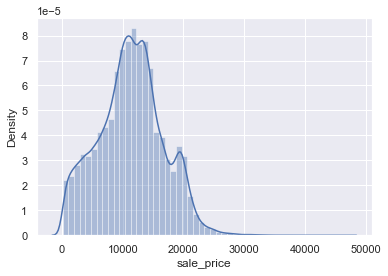

In [119]:
sns.distplot(cars['sale_price']);

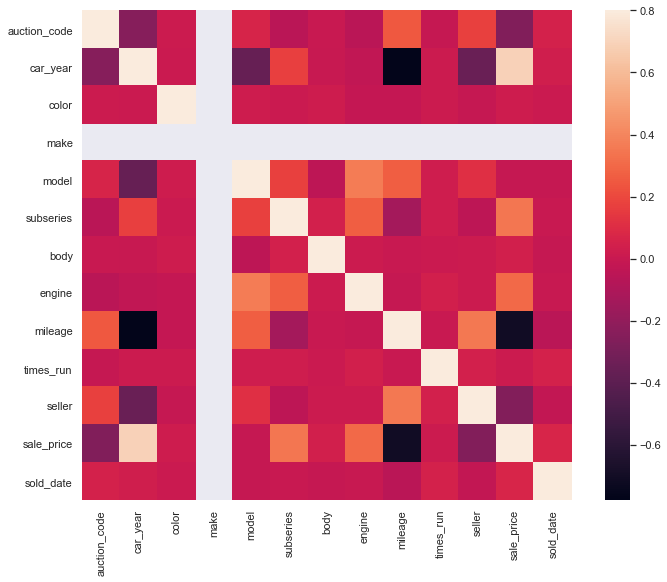

In [120]:
#correlation matrix
corrmat = cars.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,);

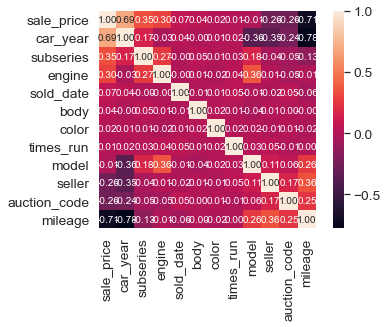

In [121]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sale_price')['sale_price'].index
cm = np.corrcoef(cars[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

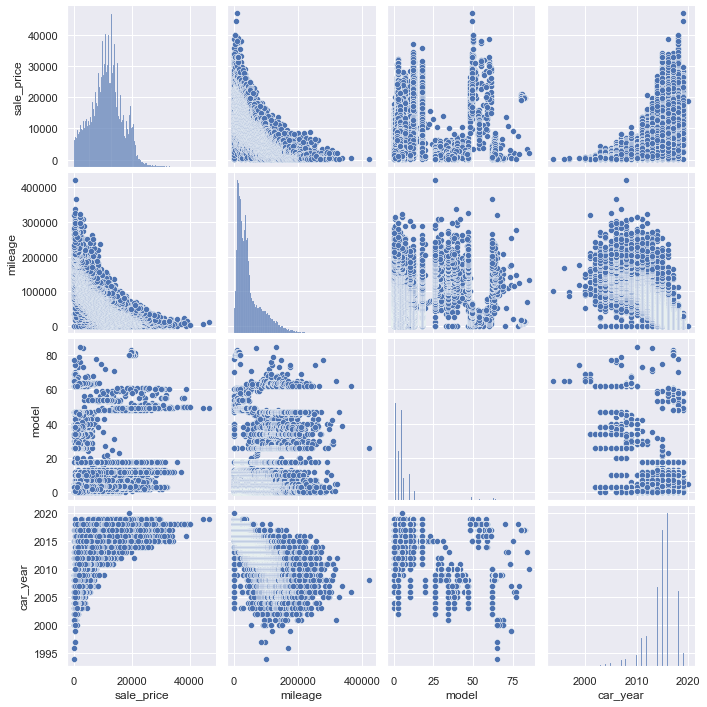

In [122]:
sns.set()
cols = ['sale_price', 'mileage', 'model', 'car_year', 'condition_grade']
sns.pairplot(cars[cols], height = 2.5)
plt.show();

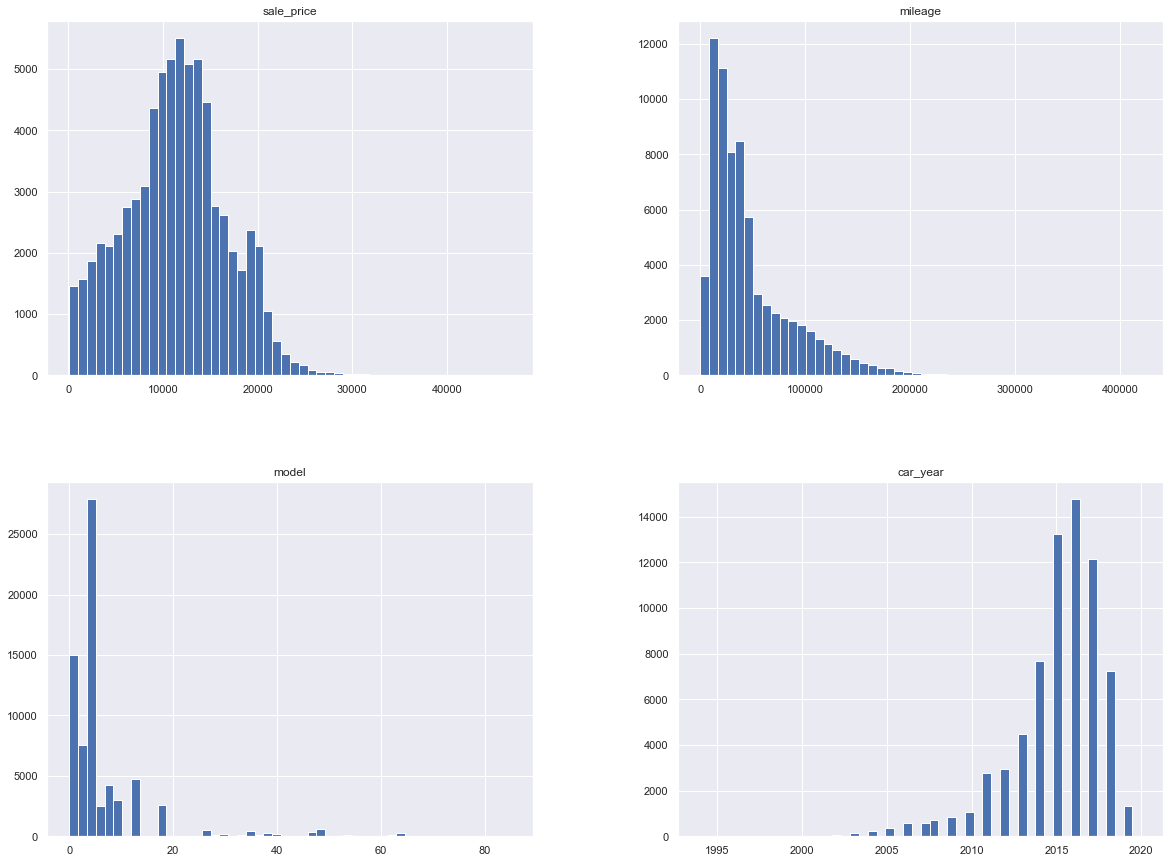

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
cars[['sale_price', 'mileage', 'model', 'car_year', 'condition_grade']].hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [124]:
#applying log transformation
import numpy as np
cars['mileage'] = np.log(cars['mileage'])
cars['car_year'] = np.log(cars['car_year'])

C:\Users\cagoff\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Variable Selection

In [125]:
# Create the x and y variables for combined score
X = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [125]:
# Create the x and y variables for driver score
X_driver = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y_driver = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [125]:
# Create the x and y variables for standard auto score
X_stdauto = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y_stdauto = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [125]:
# Create the x and y variables for mvr score
X_mvr = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y_mvr = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [125]:
# Create the x and y variables for antique auto score
X_antauto = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y_antauto = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [125]:
# Create the x and y variables for household score
X_house = cars.drop(['auction_code', 'color', 'make', 'subseries', 'body', 'engine', 'times_run', 'sold_date', 'seller', 'sale_price', 'season', 'region', 'transmission'], axis = 1)
selectedfeatures = X.columns
print(selectedfeatures)

y_house = cars['sale_price']

Index(['car_year', 'model', 'mileage', 'condition_grade'], dtype='object')


In [100]:
#Create dummy variables
#cars = pd.get_dummies(cars)

## Creating training and test datasets

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

In [127]:
X_train.head()

,car_year,model,mileage,condition_grade
3588,7.609367,6,9.460165,43
32012,7.608374,2,10.782575,38
51119,7.607878,10,11.889360,37
6680,7.608871,10,9.886545,44
39160,7.608871,4,9.249273,44


In [129]:
cars.dropna(how='all')

,auction_code,car_year,color,make,model,subseries,body,engine,transmission,mileage,condition_grade,times_run,seller,sale_price,sold_date,season,region
0,0,7.608374,0,0,0,0,0,0,0,7.545390,46,1,5361856,8500,0,Fall,Canada
1,1,7.609367,1,0,1,0,0,0,0,7.948385,50,1,5357510,14000,1,Spring,Canada
2,0,7.609862,2,0,2,0,1,0,0,8.608495,45,2,4920595,22500,2,Summer,Canada
3,1,7.609862,3,0,3,1,2,1,0,8.824678,46,2,4998915,28000,3,Spring,Canada
4,0,7.608871,4,0,4,0,0,0,0,9.143987,40,1,4903345,14000,4,Spring,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71197,47,7.605890,2,0,1,2,0,0,0,12.429644,19,1,4925422,500,238,Fall,West
71198,32,7.604396,0,0,46,2,5,1,0,12.429956,26,1,5031183,1750,282,Spring,West
71199,54,7.606885,0,0,3,0,5,1,0,12.449975,29,1,5023515,1100,350,Winter,West
71200,12,7.603898,2,0,34,2,0,0,0,12.501180,16,2,4912451,300,24,Fall,West


## GLM regression model

In [131]:
from sklearn import linear_model
clf = linear_model.TweedieRegressor()
X = [[1, 2], [2, 3], [3, 4], [4, 3]]
y = [2, 3.5, 5, 5.5]
clf.fit(X, y)

clf.score(X, y)

clf.coef_

clf.intercept_

clf.predict([[1, 1], [3, 4]])




#LinearRegression
#reg = LinearRegression()
#reg.fit(X_train, y_train)
#print("Accuracy Score of Linear regression on train set",reg.score(X_train,y_train))
#print("Accuracy Score of Linear regression on test set",reg.score(X_test,y_test))

# create a new column for the predicted salary
#hitters["reg_predict"] = reg.predict(X)

array([2.50003702, 4.59999359])

In [35]:
# p-values for the variables

import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.OLS(y_train,X_train).fit()
print(results.summary())

AttributeError: module 'statsmodels.formula.api' has no attribute 'OLS'

In [36]:
# Model Evaluation2: Calculate Root Mean Square Error (RMSE)
y_pred = reg.predict(X_test)
reg_mse = mean_squared_error(y_pred, y_test)
reg_rmse = np.sqrt(reg_mse)
print('Liner Regression RMSE: %.4f' % reg_rmse)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [15]:
# Model Evaluation3: Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 0.4484


## Neural network model

In [23]:
# To improve the neural network performance, normalize the input variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

In [24]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30), max_iter=2000)
mlp.fit(X_train_nn,y_train)
print("Accuracy Score of Neural Network on train set",mlp.score(X_train_nn,y_train))
print("Accuracy Score of Neural Network on test set",mlp.score(X_test_nn,y_test))

hitters["mlp_predict"] = mlp.predict(X)

Accuracy Score of Neural Network on train set -0.0001649277098982882
Accuracy Score of Neural Network on test set -0.004990255175479019


In [25]:
y_pred_mlp = mlp.predict(X_test_nn)
mlp_mse = mean_squared_error(y_pred_mlp, y_test)
mlp_rmse = np.sqrt(mlp_mse)
print('Neural Network RMSE: %.4f' % mlp_rmse)

Neural Network RMSE: 0.5943


In [26]:
# Model Evaluation3: Calculate mean absolute error (MAE)
mlp_mae = mean_absolute_error(y_pred_mlp, y_test)
print('Neural Network MAE: %.4f' % mlp_mae)

Neural Network MAE: 0.4565
